# Topology (Persistent Homology) Detector on MNIST (via `src/api.py`)

This notebook validates that the **public pipeline API** supports an external image dataset (MNIST)
through the built-in `TorchvisionDatasetSpec` (registry key: `mnist`).

Flow:
- load MNIST via `api.get_dataset('mnist', ...)`
- (optional) subsample splits for speed
- train a small CNN (`CNN`)
- generate adversarial examples (FGSM/PGD)
- compute topology scores in feature space
- fit a `topology_score` detector on validation scores
- evaluate detection metrics


In [12]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Ensure repo root on path
cwd = Path.cwd().resolve()
project_root = cwd if (cwd / "src").is_dir() else (cwd.parent if (cwd.parent / "src").is_dir() else cwd)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src import api
from src.utils import ExperimentConfig, set_seed
from src.data import DatasetBundle
from src.visualization import plot_roc_from_metrics, plot_score_distributions_figure

print("PROJECT_ROOT:", project_root)
print("MNIST in registry:", "mnist" in api.list_datasets())


PROJECT_ROOT: /Users/svenhockers/Desktop/pipeline
MNIST in registry: True


In [13]:
# Config
SEED = 42
set_seed(SEED)

# DEVICE = "cuda" if (os.environ.get("FORCE_CPU", "0") != "1") else "cpu"
DEVICE = "cpu"

cfg = ExperimentConfig(seed=SEED, device=DEVICE)

# Torchvision dataset options
cfg.data.root = "./data"
cfg.data.download = True
cfg.data.train_ratio = 0.9
cfg.data.val_ratio = 0.1

# Training
cfg.model.epochs = 3
cfg.model.batch_size = 64
cfg.model.learning_rate = 1e-3
cfg.model.output_dim = 10

# Attack (MNIST in [0,1])
cfg.attack.attack_type = "pgd"  # 'fgsm' or 'pgd'
cfg.attack.epsilon = 0.2
cfg.attack.num_steps = 10
cfg.attack.step_size = 0.04
cfg.attack.random_start = True

# Topology scoring in feature space
cfg.graph.space = "feature"
cfg.graph.use_topology = True
cfg.graph.use_tangent = False
cfg.graph.topo_k = 40
cfg.graph.topo_maxdim = 1
cfg.graph.topo_preprocess = "pca"
cfg.graph.topo_pca_dim = 10
cfg.graph.topo_min_persistence = 1e-6

# Detector
cfg.detector.detector_type = "topology_score"
cfg.detector.topo_percentile = 95.0
cfg.detector.topo_cov_shrinkage = 1e-3


## Load MNIST (API) + optional subsampling


In [14]:
bundle_full = api.get_dataset("mnist", cfg)
print("Full bundle shapes:")
print("  X_train:", bundle_full.X_train.shape, "y_train:", bundle_full.y_train.shape)
print("  X_val:  ", bundle_full.X_val.shape, "y_val:  ", bundle_full.y_val.shape)
print("  X_test: ", bundle_full.X_test.shape, "y_test: ", bundle_full.y_test.shape)

# Subsample to keep runs fast (optional, but recommended for PH)
N_TRAIN = 6000
N_VAL = 1000
N_TEST = 1000

rng = np.random.default_rng(SEED)
idx_tr = rng.choice(len(bundle_full.X_train), size=min(N_TRAIN, len(bundle_full.X_train)), replace=False)
idx_va = rng.choice(len(bundle_full.X_val), size=min(N_VAL, len(bundle_full.X_val)), replace=False)
idx_te = rng.choice(len(bundle_full.X_test), size=min(N_TEST, len(bundle_full.X_test)), replace=False)

bundle = DatasetBundle(
    bundle_full.X_train[idx_tr], bundle_full.y_train[idx_tr],
    bundle_full.X_val[idx_va], bundle_full.y_val[idx_va],
    bundle_full.X_test[idx_te], bundle_full.y_test[idx_te],
    meta=dict(bundle_full.meta),
)

print("Subsampled bundle shapes:")
print("  X_train:", bundle.X_train.shape)
print("  X_val:  ", bundle.X_val.shape)
print("  X_test: ", bundle.X_test.shape)


Full bundle shapes:
  X_train: (54000, 1, 28, 28) y_train: (54000,)
  X_val:   (6000, 1, 28, 28) y_val:   (6000,)
  X_test:  (10000, 1, 28, 28) y_test:  (10000,)
Subsampled bundle shapes:
  X_train: (6000, 1, 28, 28)
  X_val:   (1000, 1, 28, 28)
  X_test:  (1000, 1, 28, 28)


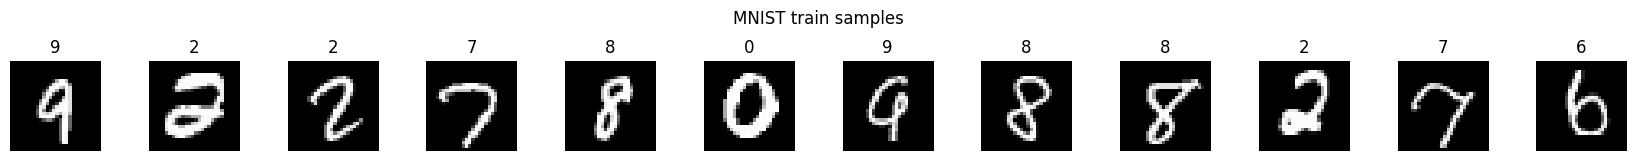

In [15]:
# Visual sanity-check
def show_grid(X: np.ndarray, y: np.ndarray, *, n: int = 12, title: str = "samples"):
    n = int(min(n, len(X)))
    fig, axes = plt.subplots(1, n, figsize=(1.4 * n, 1.6))
    for i in range(n):
        img = X[i, 0] if X.ndim == 4 else X[i]
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(str(int(y[i])))
        axes[i].axis("off")
    plt.suptitle(title)
    plt.tight_layout(); plt.show()

show_grid(bundle.X_train, bundle.y_train, title="MNIST train samples")


## Train model (API)


In [16]:
model = api.get_model(
    "CNN",
    cfg,
    num_classes=10,
    in_channels=1,
    feat_dim=128,
)

model = api.train(model, bundle, cfg, device=str(cfg.device), verbose=True, return_history=False)

pred_test = api.predict(model, bundle.X_test, device=str(cfg.device), return_probs=False)
test_acc = 100.0 * float(np.mean(pred_test == np.asarray(bundle.y_test, dtype=int)))
print(f"Test accuracy: {test_acc:.2f}%")


Test accuracy: 52.50%


## Attacks + topology-score detector (API)


In [ ]:
X_adv_val = api.generate_adversarial(model, bundle.X_val, bundle.y_val, cfg, clip=bundle.meta.get("clip"))
X_adv_test = api.generate_adversarial(model, bundle.X_test, bundle.y_test, cfg, clip=bundle.meta.get("clip"))

FILTER_CLEAN_TO_CORRECT = True
EVAL_ONLY_SUCCESSFUL_ATTACKS = True

clean_mask_val = np.ones(len(bundle.X_val), dtype=bool)
clean_mask_test = np.ones(len(bundle.X_test), dtype=bool)
if FILTER_CLEAN_TO_CORRECT:
    pred_val = api.predict(model, bundle.X_val, device=str(cfg.device), return_probs=False)
    pred_test = api.predict(model, bundle.X_test, device=str(cfg.device), return_probs=False)
    clean_mask_val = pred_val == np.asarray(bundle.y_val, dtype=int)
    clean_mask_test = pred_test == np.asarray(bundle.y_test, dtype=int)

adv_mask_val = np.ones(len(X_adv_val), dtype=bool)
adv_mask_test = np.ones(len(X_adv_test), dtype=bool)
if EVAL_ONLY_SUCCESSFUL_ATTACKS:
    adv_mask_val = api.attack_success_mask(model, bundle.X_val, X_adv_val, bundle.y_val, device=str(cfg.device))
    adv_mask_test = api.attack_success_mask(model, bundle.X_test, X_adv_test, bundle.y_test, device=str(cfg.device))

print(f"Val successful attacks:  {adv_mask_val.sum()}/{len(adv_mask_val)} = {adv_mask_val.mean():.3f}")
print(f"Test successful attacks: {adv_mask_test.sum()}/{len(adv_mask_test)} = {adv_mask_test.mean():.3f}")

# Subsample scoring points for PH runtime
MAX_POINTS_FOR_SCORING = 300
X_val_clean_used, _ = api.subsample_masked(bundle.X_val, bundle.y_val, clean_mask_val, MAX_POINTS_FOR_SCORING, seed=SEED)
X_val_adv_used, _ = api.subsample_masked(X_adv_val, bundle.y_val, adv_mask_val, MAX_POINTS_FOR_SCORING, seed=SEED + 1)
X_test_clean_used, _ = api.subsample_masked(bundle.X_test, bundle.y_test, clean_mask_test, MAX_POINTS_FOR_SCORING, seed=SEED + 2)
X_test_adv_used, _ = api.subsample_masked(X_adv_test, bundle.y_test, adv_mask_test, MAX_POINTS_FOR_SCORING, seed=SEED + 3)

# Scores
scores_val_clean = api.compute_scores(X_val_clean_used, model, bundle=bundle, cfg=cfg)
scores_val_adv = api.compute_scores(X_val_adv_used, model, bundle=bundle, cfg=cfg)
scores_test_clean = api.compute_scores(X_test_clean_used, model, bundle=bundle, cfg=cfg)
scores_test_adv = api.compute_scores(X_test_adv_used, model, bundle=bundle, cfg=cfg)

# Fit detector on val
scores_val_all = api.concat_scores(scores_val_clean, scores_val_adv)
any_key = next(iter(scores_val_all.keys()))
labels_val = np.concatenate([
    np.zeros(len(scores_val_clean[any_key]), dtype=int),
    np.ones(len(scores_val_adv[any_key]), dtype=int),
])
detector = api.fit_detector(scores_val_all, labels_val, cfg)

# Evaluate on test
scores_test_all = api.concat_scores(scores_test_clean, scores_test_adv)
any_key_t = next(iter(scores_test_all.keys()))
labels_test = np.concatenate([
    np.zeros(len(scores_test_clean[any_key_t]), dtype=int),
    np.ones(len(scores_test_adv[any_key_t]), dtype=int),
])

raw_scores_test = np.asarray(detector.score(scores_test_all), dtype=float)
metrics = api.evaluate_detection(labels_test, raw_scores_test)

print("\nDetector metrics:")
print(f"  AUROC:     {metrics['roc_auc']:.4f}")
print(f"  AUPRC:     {metrics['pr_auc']:.4f}")
print(f"  FPR@95TPR: {metrics['fpr_at_tpr95']:.4f}")
print(f"  threshold: {float(getattr(detector, 'threshold', np.nan)):.4f}")

# Quick visualizations
plot_roc_from_metrics(metrics, title=f"ROC: MNIST ({cfg.attack.attack_type}, eps={cfg.attack.epsilon})")
thr = float(getattr(detector, 'threshold', np.nan))
raw_clean = raw_scores_test[: len(scores_test_clean[any_key_t])]
raw_adv = raw_scores_test[len(scores_test_clean[any_key_t]):]
plot_score_distributions_figure(
    raw_clean,
    raw_adv,
    score_name="topology_mahalanobis score",
    title="Topology score distribution (test)",
    bins=40,
    threshold=thr,
    labels=("clean", "adversarial"),
    alpha=0.6,
    density=True,
    figsize=(7, 4),
)


Val successful attacks:  525/1000 = 0.525
Test successful attacks: 523/1000 = 0.523
